Tutorial 6: More Ray Tracing
============================

We'll now reinforce the ideas that we learnt about ray-tracing in the previous tutorial and introduce the following
new concepts:

 - That a `Tracer` can be given any number of galaxies.
 - That by specifying redshifts and a cosmology, the results are converted from arc-second coordinates to physical
 units of kiloparsecs (kpc). Again, if you're not an Astronomer, you may not be familiar with the unit of parsec, it
 may be worth a quick Google!

Up to now, the planes have also had just one lens galaxy or source galaxy at a time. In this example, the tracer will
have multiple galaxies at each redshift, meaning that each plane has more than one galaxy. In terms of lensing
calculations:

- If two or more lens galaxies are at the same redshift in the image-plane, the convergences, potentials and
deflection angles of their mass profiles are summed when performing lensing calculations.

- If two or more source galaxies are at the same redshift in the source-plane, their light can simply be summed before
ray tracing.

The `Tracer` fully accounts for this.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

from astropy import cosmology

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

To begin, lets setup the grid we'll ray-trace using. But, lets do something crazy and use a higher resolution than 
the previous tutorials!

Lets also stop calling it the `image_plane_grid`, and just remember from now on our `grid` is in the image-plane.

In [2]:
grid = al.Grid2D.uniform(shape_native=(250, 250), pixel_scales=0.02)

The grid is now shape 250 x 250, which has more image-pixels than the 100 x 100 grid used previously.

In [3]:
print(grid.shape_native)
print(grid.shape_slim)

(250, 250)
62500


__Concise Code__

Next, lets setup a lens galaxy. Up to now we have we set up each profile one line at a time, making the code long and 
cumbersome to read. 

From now on, we'll set up each galaxy with a single block of code, making it more concise and readable.
 
we'll also give the lens galaxy some attributes we didn`t in the last tutorial:

 - A light profile representing a `bulge` of stars, meaning the lens galaxy's light will appear in the image for the
 first time.
 - An external shear, which accounts for the deflection of light due to line-of-sight structures.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.SphSersic(
        centre=(0.0, 0.0), intensity=2.0, effective_radius=0.5, sersic_index=2.5
    ),
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.0, -0.111111), einstein_radius=1.6
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.0)),
)

print(lens_galaxy)

Redshift: 0.5
Light Profiles:
SphSersic
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
angle: 0.0
intensity: 2.0
effective_radius: 0.5
sersic_index: 2.5
Mass Profiles:
EllIsothermal
centre: (0.0, 0.0)
elliptical_comps: (0.0, -0.111111)
axis_ratio: 0.800000180000018
angle: 90.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0
ExternalShear
centre: (0.0, 0.0)
elliptical_comps: (0.05, 0.0)
axis_ratio: 0.9047619047619047
angle: 45.0
magnitude: 0.05


Lets also create a small satellite galaxy nearby the lens galaxy and at the same redshift.

In [5]:
lens_satellite = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.SphDevVaucouleurs(
        centre=(1.0, 0.0), intensity=2.0, effective_radius=0.2
    ),
    mass=al.mp.SphIsothermal(centre=(1.0, 0.0), einstein_radius=0.4),
)

print(lens_satellite)

Redshift: 0.5
Light Profiles:
SphDevVaucouleurs
centre: (1.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
angle: 0.0
intensity: 2.0
effective_radius: 0.2
sersic_index: 4.0
Mass Profiles:
SphIsothermal
centre: (1.0, 0.0)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
angle: 0.0
einstein_radius: 0.4
slope: 2.0
core_radius: 0.0


Lets have a quick look at the appearance of our lens galaxy and its satellite.

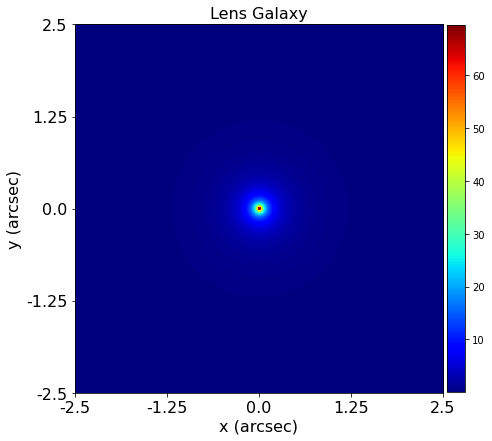

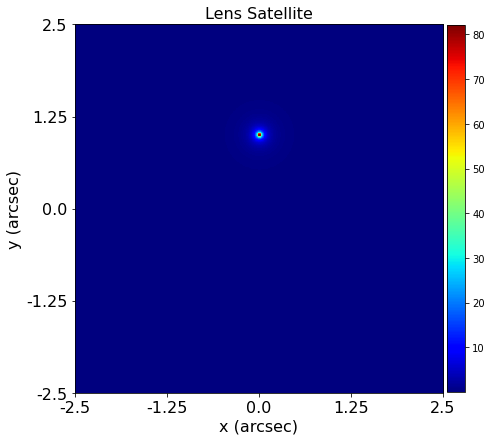

In [6]:
mat_plot_2d = aplt.MatPlot2D(title=aplt.Title(label="Lens Galaxy"))

galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens_galaxy, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.figures_2d(image=True)

mat_plot_2d = aplt.MatPlot2D(title=aplt.Title(label="Lens Satellite"))

galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens_satellite, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.figures_2d(image=True)

And their deflection angles, noting that the satellite does not contribute as much to the deflections.

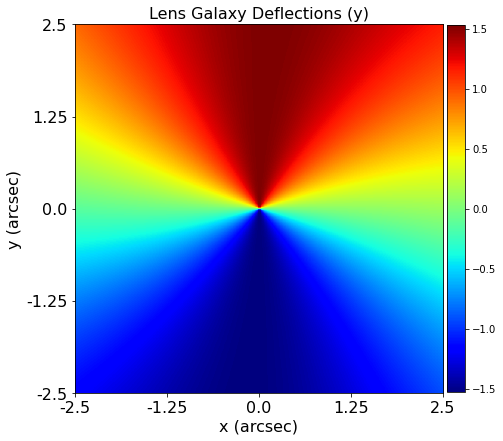

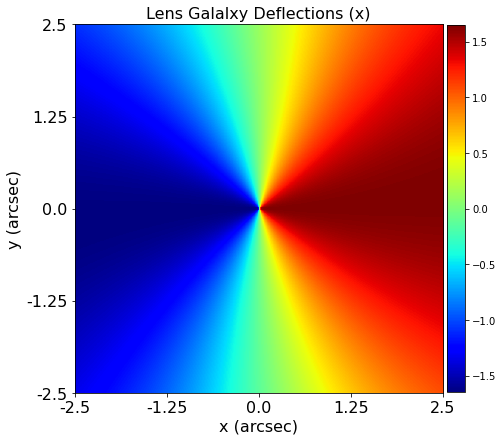

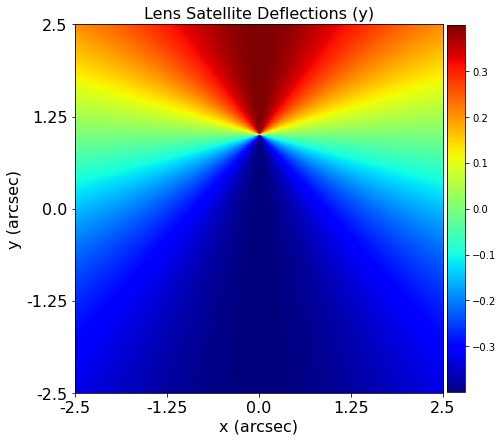

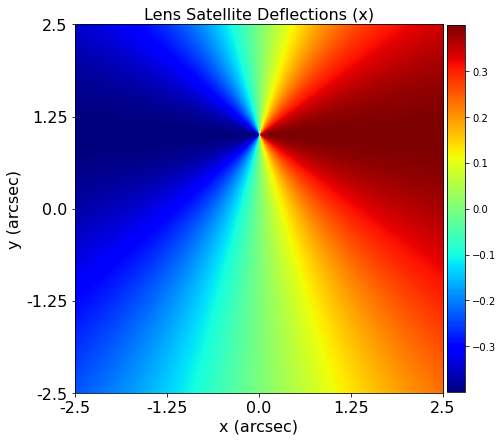

In [7]:
mat_plot_2d = aplt.MatPlot2D(title=aplt.Title(label="Lens Galaxy Deflections (y)"))

galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=lens_galaxy, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.figures_2d(deflections_y=True)

# NOTE: It would be annoying to have to reset the title for every plot using the following code:

# mat_plot_2d = aplt.MatPlot2D(
#     title=aplt.Title(label="Lens Galalxy Deflections (x)")
# )
# galaxy_plotter = aplt.GalaxyPlotter(galaxy=lens_galaxy, grid=grid, mat_plot_2d=mat_plot_2d)

# We can set the title more conveniently as follows:

galaxy_plotter.set_title("Lens Galalxy Deflections (x)")
galaxy_plotter.figures_2d(deflections_x=True)

galaxy_plotter = aplt.GalaxyPlotter(galaxy=lens_satellite, grid=grid)
galaxy_plotter.set_title("Lens Satellite Deflections (y)")
galaxy_plotter.figures_2d(deflections_y=True)
galaxy_plotter.set_title("Lens Satellite Deflections (x)")
galaxy_plotter.figures_2d(deflections_x=True)

Now, lets make two source galaxies at redshift 1.0. Instead of using the name `light` for the light profiles, lets 
instead use more descriptive names that indicate what morphological component of the galaxy the light profile 
represents. In this case, we'll use the terms `bulge` and `disk`, the two main structures that a galaxy can be made of

In [8]:
source_galaxy_0 = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.SphDevVaucouleurs(
        centre=(0.1, 0.2), intensity=0.3, effective_radius=0.3
    ),
    disk=al.lp.EllExponential(
        centre=(0.1, 0.2),
        elliptical_comps=(0.111111, 0.0),
        intensity=3.0,
        effective_radius=2.0,
    ),
)

source_galaxy_1 = al.Galaxy(
    redshift=1.0,
    disk=al.lp.EllExponential(
        centre=(-0.3, -0.5),
        elliptical_comps=(0.1, 0.0),
        intensity=8.0,
        effective_radius=1.0,
    ),
)

print(source_galaxy_0)
print(source_galaxy_1)

Redshift: 1.0
Light Profiles:
SphDevVaucouleurs
centre: (0.1, 0.2)
elliptical_comps: (0.0, 0.0)
axis_ratio: 1.0
angle: 0.0
intensity: 0.3
effective_radius: 0.3
sersic_index: 4.0
EllExponential
centre: (0.1, 0.2)
elliptical_comps: (0.111111, 0.0)
axis_ratio: 0.800000180000018
angle: 45.0
intensity: 3.0
effective_radius: 2.0
sersic_index: 1.0
Redshift: 1.0
Light Profiles:
EllExponential
centre: (-0.3, -0.5)
elliptical_comps: (0.1, 0.0)
axis_ratio: 0.8181818181818181
angle: 45.0
intensity: 8.0
effective_radius: 1.0
sersic_index: 1.0


Lets look at our source galaxies (before lensing)

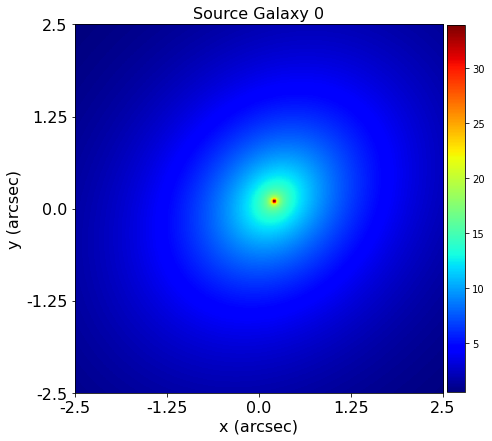

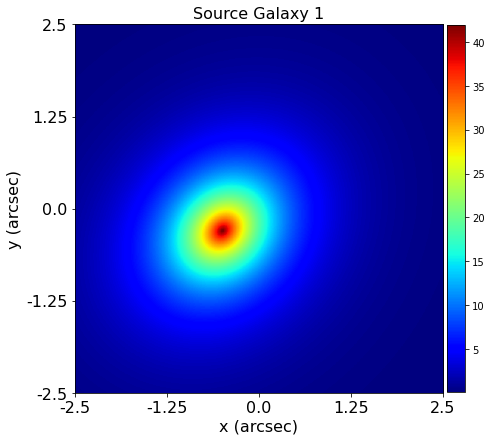

In [9]:
galaxy_plotter = aplt.GalaxyPlotter(
    galaxy=source_galaxy_0, grid=grid, mat_plot_2d=mat_plot_2d
)
galaxy_plotter.set_title("Source Galaxy 0")
galaxy_plotter.figures_2d(image=True)

galaxy_plotter = aplt.GalaxyPlotter(galaxy=source_galaxy_1, grid=grid)
galaxy_plotter.set_title("Source Galaxy 1")
galaxy_plotter.figures_2d(image=True)

__Multi Galaxy Ray Tracing__

Now lets pass our 4 galaxies to a `Tracer`, which means the following will occur:

 - Using the galaxy redshift`s, and image-plane and source-plane will be created each with two galaxies galaxies.

We've also pass the tracer below a Planck15 cosmology, where the cosomology of the Universe describes exactly how 
ray-tracing is performed.

In [10]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy, lens_satellite, source_galaxy_0, source_galaxy_1],
    cosmology=cosmology.Planck15,
)

We can now plot the tracer`s image, which now there are two galaxies in each plane is computed as follows:

 1) First, using the image-plane grid, the images of the lens galaxy and its satellite are computed.

 2) Using the mass profiles of the lens and its satellite, their deflection angles are computed.

 3) These deflection angles are summed, such that the deflection of light due to the mass profiles of both galaxies in 
 the image-plane is accounted for.

 4) These deflection angles are used to trace every image-grid coordinate to the source-plane.

 5) The image of the source galaxies is computed by summing both of their images and ray-tracing their light back to 
 the image-plane.
 
This process is pretty much the same as we have single in previous tutorials when there is one galaxy per plane. We
are simply summing the images and deflection angles of the galaxies before using them to perform ray-tracing.

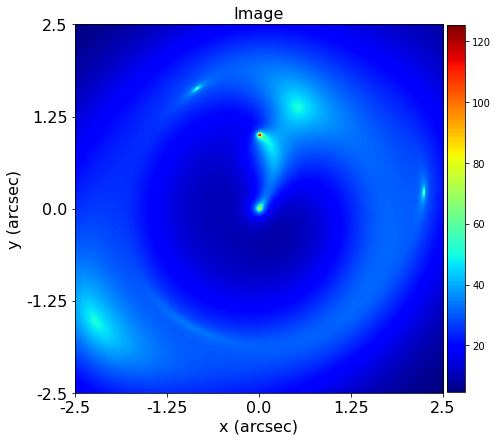

In [11]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.set_title("Image")
tracer_plotter.figures_2d(image=True)

As we did previously, we can plot the source plane grid to see how each coordinate was traced. 

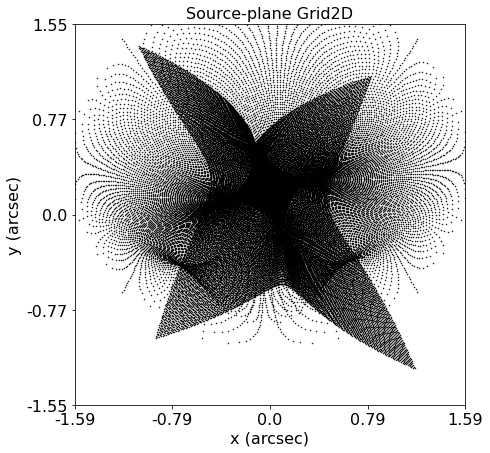

In [12]:
tracer_plotter.set_title("Source-plane Grid2D")
tracer_plotter.figures_2d_of_planes(plane_grid=True, plane_index=1)

We can zoom in on the source-plane to reveal the inner structure of the caustic.

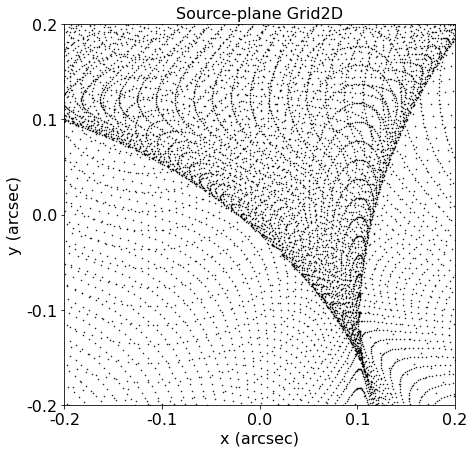

In [13]:
mat_plot_2d = aplt.MatPlot2D(axis=aplt.Axis(extent=[-0.2, 0.2, -0.2, 0.2]))

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.set_title("Source-plane Grid2D")
tracer_plotter.figures_2d_of_planes(plane_grid=True, plane_index=1)

__Units__

Lets plot the lensing quantities again. However, we'll now use the `Units` object of the **PyAutoLens** plotter module 
to set `in_kpc=True` and therefore plot the y and x axes in kiloparsecs.

This conversion is performed automatically, using the galaxy redshifts and cosmology.

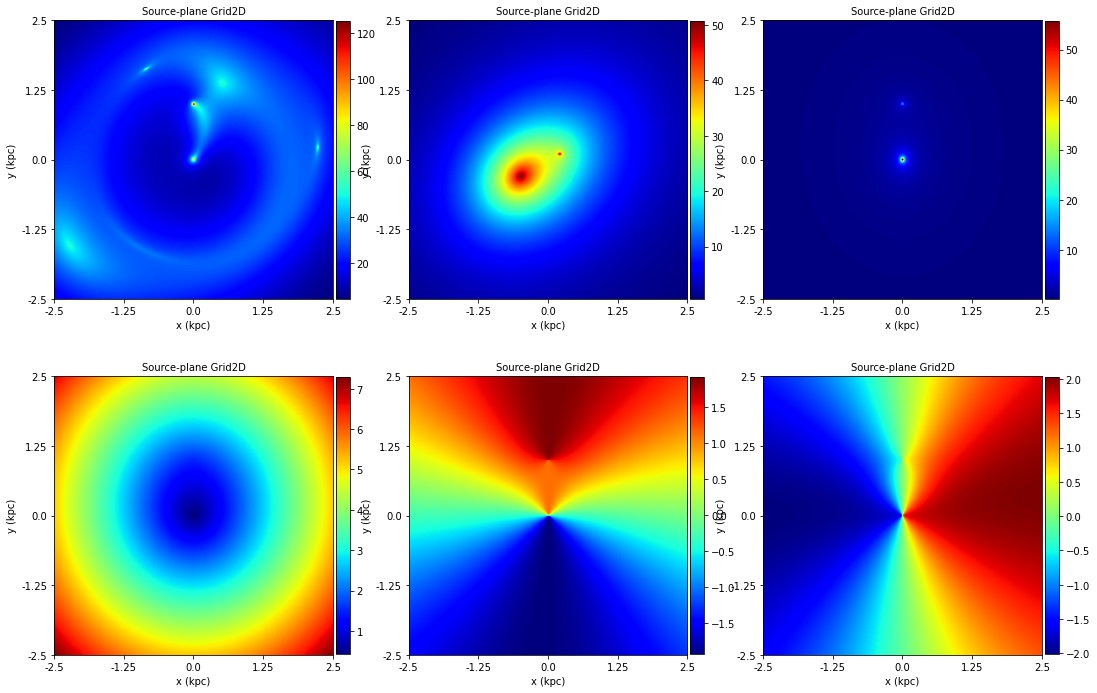

In [14]:
mat_plot_2d = aplt.MatPlot2D(units=aplt.Units(in_kpc=True))

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()

If you're too familiar with Cosmology, it will be unclear how exactly we converted the distance units from 
arcseconds to kiloparsecs. You'll need to read up on your Cosmology lecture to understand this properly.

The `util.cosmology` method provides many methods for calculation different cosmological quantites, which are shown 
below (if you're not too familiar with cosmology don't worry that you don't know what these mean, it isn't massively
important for using **PyAutoLens**).

In [15]:
cosmology = tracer.cosmology

print("Image-plane arcsec-per-kpc:")
print(al.util.cosmology.arcsec_per_kpc_from(redshift=0.5, cosmology=cosmology))
print("Image-plane kpc-per-arcsec:")
print(al.util.cosmology.kpc_per_arcsec_from(redshift=0.5, cosmology=cosmology))
print("Angular Diameter Distance to Image-plane (kpc):")
print(
    al.util.cosmology.angular_diameter_distance_to_earth_in_kpc_from(
        redshift=0.5, cosmology=cosmology
    )
)

print("Source-plane arcsec-per-kpc:")
print(al.util.cosmology.arcsec_per_kpc_from(redshift=1.0, cosmology=cosmology))
print("Source-plane kpc-per-arcsec:")
print(al.util.cosmology.kpc_per_arcsec_from(redshift=1.0, cosmology=cosmology))
print("Angular Diameter Distance to Source-plane:")
print(
    al.util.cosmology.angular_diameter_distance_to_earth_in_kpc_from(
        redshift=1.0, cosmology=cosmology
    )
)

print("Angular Diameter Distance From Image To Source Plane:")
print(
    al.util.cosmology.angular_diameter_distance_between_redshifts_in_kpc_from(
        redshift_0=0.5, redshift_1=1.0, cosmology=cosmology
    )
)
print("Lensing Critical convergence:")
print(
    al.util.cosmology.critical_surface_density_between_redshifts_solar_mass_per_kpc2_from(
        redshift_0=0.5, redshift_1=1.0, cosmology=cosmology
    )
)

Image-plane arcsec-per-kpc:
0.1590272254082433
Image-plane kpc-per-arcsec:
6.288231448626936
Angular Diameter Distance to Image-plane (kpc):
1297040.8413879331
Source-plane arcsec-per-kpc:
0.12147853800264835
Source-plane kpc-per-arcsec:
8.231906774990978
Angular Diameter Distance to Source-plane:
1697952.655987674
Angular Diameter Distance From Image To Source Plane:
725172.0249467241
Lensing Critical convergence:
3001935359.3527756


__Wrap Up__

Tutorial 6 completed! Try the following:

 1) If you change the lens and source galaxy redshifts, does the tracer's image change?

 2) What happens to the cosmological quantities as you change these redshifts? Do you remember enough of your 
 cosmology lectures to predict how quantities like the angular diameter distance change as a function of redshift?

 3) The tracer has a small delay in being computed, whereas other tracers were almost instant. What do you think 
 is the cause of this slow-down?